#Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk

In [ ]:
#read data
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/6000/tweet-sentiment-extraction/train.csv', header = 0).dropna()

In [ ]:
def jaccard(str1, str2): 
    a = set(str(str1).lower().split()) 
    b = set(str(str2).lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

#Partition

In [ ]:
Y = train['selected_text']
X = train.drop(columns=['selected_text'])
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.2, random_state=1)

In [ ]:
Y_train = pd.DataFrame(Y_train)
train = X_train.join(Y_train)
test = X_test.copy()
Y_test = pd.DataFrame(Y_test)
sample = X_test.join(Y_test)

In [ ]:
index1 = pd.DataFrame([i for i in range(train.shape[0])])
train.set_index(index1[0],inplace= True)

In [ ]:
index2 = pd.DataFrame([i for i in range(test.shape[0])])
test.set_index(index2[0],inplace= True)

In [ ]:
index3 = pd.DataFrame([i for i in range(sample.shape[0])])
sample.set_index(index3[0],inplace= True)

# Processing

neutral

In [ ]:
v1 = train.loc[train.sentiment=='neutral', 'text'].values.tolist()
v2 = train.loc[train.sentiment=='neutral', 'selected_text'].values.tolist()
np.mean([jaccard(w1, w2) for w1, w2 in zip(v1, v2)])

0.9759715608685855

In [ ]:
isNeutral = test.loc[test['sentiment'] == 'neutral', 'textID'].values.tolist()
def get_selected_text_neutral(textID, df=test):
    if textID in isNeutral:
        return df.loc[df.textID==textID, 'text'].values.tolist()[0]
    else:
        return np.nan
def treat_neutral(test):
    test['selected_text'] = test['textID'].apply(get_selected_text_neutral, df=test)
    return test
sample_submission = treat_neutral(test)
sample_submission.head()

,textID,text,sentiment,selected_text
0,,,,
0,50726f1adb,smH daTs whacK,neutral,smH daTs whacK
1,8a87bf47ff,"oh dear, thats not good - I hope you get thro...",neutral,"oh dear, thats not good - I hope you get thro..."
2,f90dccdae7,"this hole twitter thing is new too me, its not...",negative,NaN
3,884476afed,"@_elj Appreciated,uni email is helpful..",positive,NaN
4,1f27adbaa5,", Just read an article that buying IP`s doesn...",neutral,", Just read an article that buying IP`s doesn..."


pos&neg

In [ ]:
from nltk import pos_tag, ngrams
# nltk.download('wordnet')
from nltk.corpus import sentiwordnet as swn, wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
import string
filtre = [wn.NOUN, wn.ADJ, wn.ADV, wn.VERB]

In [ ]:
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    else:
        return None

In [ ]:
def get_sentiment(word, tag, verbose=0):
    """ returns list of pos neg and objective score. But returns empty list if not present in senti wordnet. """
    wn_tag = penn_to_wn(tag)
    if wn_tag not in filtre:
        return []

    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if verbose:
        print(f'Lemmatizer : {lemma}')
    if not lemma:
        return []

    synsets = wn.synsets(word, pos=wn_tag)
    if verbose:
        print(f'Synsets : {synsets}')
    if not synsets:
        return []

    swn_synset_pos = []
    swn_synset_neg = []
    for synset in synsets:
        swn_synset = swn.senti_synset(synset.name())
        if verbose:
            print(f'Pos score : {swn_synset.pos_score()}, Neg score : {swn_synset.neg_score()}')
        swn_synset_pos.append(swn_synset.pos_score())
        swn_synset_neg.append(swn_synset.neg_score())
    return [np.mean(swn_synset_pos),np.mean(swn_synset_neg)]#,swn_synset.obj_score()

In [ ]:
def robustify(text=''):
    if type(text) != str:
        try:
            text = str(text)
        except:
            text = ''
    return text


In [ ]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

test['senti_val'] = test['text'].apply(score)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
test.loc[test.sentiment != 'neutral'].head()

,textID,text,sentiment,selected_text,senti_val
0,,,,,
2,f90dccdae7,"this hole twitter thing is new too me, its not...",negative,NaN,"[(hole, 0.109375), (twitter, 0.0), (thing, 0.0..."
3,884476afed,"@_elj Appreciated,uni email is helpful..",positive,NaN,"[(email, 0.0), (is, 0.028846153846153848), (he..."
7,0c5e8471ba,_04071991 haaa awesome! i remember my brother ...,positive,NaN,"[(i, 0.0), (remember, 0.109375), (brother, 0.0..."
8,654de96a93,I wanna buy a million copies. But i aint that ...,negative,NaN,"[(wan, 0.375), (buy, 0.0), (copies, 0.0), (i, ..."
10,d1d7ed938d,- great site. The photos on it are fantastic...,positive,NaN,"[(great, 0.3125), (site, 0.0), (photos, 0.0), ..."


In [ ]:
def get_selected_text(text, senti_val):
    if len(senti_val)==0:
        return text
    else:
        return ' '.join([t[0] for t in senti_val if t[1]>0.1])
test['selected_text'] = test.apply(lambda df:get_selected_text(df['text'],df['senti_val']), axis=1)
test.head()

,textID,text,sentiment,selected_text,senti_val
0,,,,,
0,50726f1adb,smH daTs whacK,neutral,smH daTs whacK,[]
1,8a87bf47ff,"oh dear, thats not good - I hope you get thro...",neutral,"oh dear, thats not good - I hope you get thro...",[]
2,f90dccdae7,"this hole twitter thing is new too me, its not...",negative,hole new too not,"[(hole, 0.109375), (twitter, 0.0), (thing, 0.0..."
3,884476afed,"@_elj Appreciated,uni email is helpful..",positive,helpful,"[(email, 0.0), (is, 0.028846153846153848), (he..."
4,1f27adbaa5,", Just read an article that buying IP`s doesn...",neutral,", Just read an article that buying IP`s doesn...",[]


In [ ]:
for i, row in test.loc[test.sentiment!='neutral'].iterrows():
    sample_submission.loc[sample_submission.textID==row['textID'], 'selected_text'] = row['selected_text']

In [ ]:
sample_submission.head()

,textID,text,sentiment,selected_text,senti_val
0,,,,,
0,50726f1adb,smH daTs whacK,neutral,smH daTs whacK,[]
1,8a87bf47ff,"oh dear, thats not good - I hope you get thro...",neutral,"oh dear, thats not good - I hope you get thro...",[]
2,f90dccdae7,"this hole twitter thing is new too me, its not...",negative,hole new too not,"[(hole, 0.109375), (twitter, 0.0), (thing, 0.0..."
3,884476afed,"@_elj Appreciated,uni email is helpful..",positive,helpful,"[(email, 0.0), (is, 0.028846153846153848), (he..."
4,1f27adbaa5,", Just read an article that buying IP`s doesn...",neutral,", Just read an article that buying IP`s doesn...",[]


#Evaluation

In [ ]:
r = pd.DataFrame(sample_submission.copy()['selected_text'])
g = pd.DataFrame(sample.copy()['selected_text'])
g.rename(columns = {'selected_text':'groud_truth'},inplace = True)
result = r.join(g)

In [ ]:
score = []

for ind,row in result.iterrows():
    sentence1 = row.groud_truth
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    score.append([sentence1,sentence2,jaccard_score])

In [ ]:
result = pd.DataFrame(score,columns=["groud_truth","selected_text","jaccard_score"])

In [ ]:
result

,groud_truth,selected_text,jaccard_score
0,smH daTs whacK,smH daTs whacK,1.000000
1,"oh dear, thats not good - I hope you get throu...","oh dear, thats not good - I hope you get thro...",1.000000
2,stuvk with the wee stpid thing fo,hole new too not,0.000000
3,uni email is helpful..,helpful,0.000000
4,", Just read an article that buying IP`s doesn`...",", Just read an article that buying IP`s doesn...",0.944444
...,...,...,...
5491,"MC, happy mother`s day to your mom ;).. love yah",happy mom love,0.300000
5492,Glad you are happy!,happy,0.000000
5493,mcfly anit been on here in ages z,mcfly anit been on here in ages z,1.000000
5494,that`s not good to hear! i hope everything is...,that`s not good to hear! i hope everything i...,0.409091


In [ ]:
result['jaccard_score'].mean()

0.5222583796752419

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


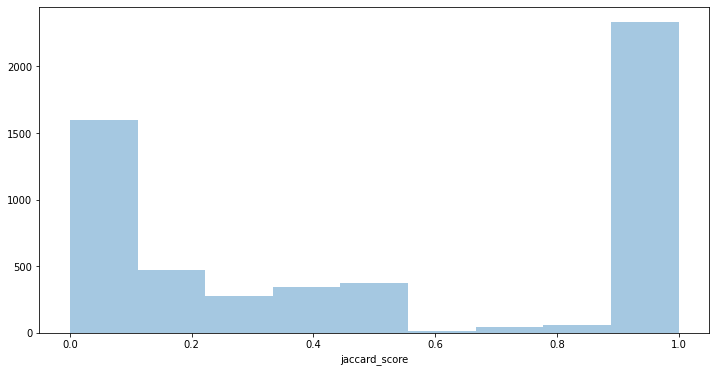

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.distplot(result['jaccard_score'],kde=False)